In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from prg import prg

In [2]:
def get_target(col):
    return col.split('.')[1].split(':')[0]

def load_target(path, target):
    try:
        return pickle.load(open('{}/{}.pkl'.format(DSC_PATH, path), 'rb'))[target]
    except Exception:
        return []

def aggregate_columns(df, keyword):
    target_cols = df.columns[[keyword in c for c in df.columns]]
    fp = pd.concat([df.loc[:, c].dropna() for c in target_cols])
    df.loc[:, keyword] = fp
    df.drop(np.delete(target_cols, np.where(target_cols == keyword)), axis=1, inplace=True)
    return df

def load_output_columns(df):
    output_columns = df.columns[['output' in c for c in df.columns]]
    targets = np.unique([get_target(oc) for oc in output_columns])
    for t in targets:
        aggregate_columns(df, '{}:output'.format(t))
        df.loc[:, t] = df.loc[:, '{}:output'.format(t)].apply(lambda x: load_target(x, t))
        df.drop('{}:output'.format(t), axis=1, inplace=True)
    return df

### Query DSC

In [3]:
DSC_PATH = '../output/cafeh-simulations'
DSC_PATH = '../prototype2/'


targets = [
    'fit_cafeh.model', 'fit_coloc.model', 'fit_ecaviar.model',
    'score_coloc_coloc.p_coloc',
    'score_coloc_cafeh.p_coloc',
    'score_coloc_ecaviar.p_coloc',
    'single_sim.true_coloc',
    'single_sim.pve', 'single_sim.n_study', 'single_sim.n_causal_per_study'
]

query_file = 'coloc.xlsx'

cmd_args = [
    'dsc-query', DSC_PATH,
    '-t', ' '.join(targets),
    '-o', query_file
]

subprocess.run('rm {}'.format(query_file), shell=True)
subprocess.run(' '.join(cmd_args), shell=True)

CompletedProcess(args='dsc-query ../prototype2/ -t fit_cafeh.model fit_coloc.model fit_ecaviar.model score_coloc_coloc.p_coloc score_coloc_cafeh.p_coloc score_coloc_ecaviar.p_coloc single_sim.true_coloc single_sim.pve single_sim.n_study single_sim.n_causal_per_study -o coloc.xlsx', returncode=0)

In [4]:
xls = pd.ExcelFile(query_file)
info = [xls.parse(x) for x in xls.sheet_names]
spec = pd.read_excel(xls, 'Sheet1')
aggregate_columns(spec, 'model')

,DSC,fit_cafeh,score_coloc_coloc.p_coloc:output,score_coloc_cafeh.p_coloc:output,score_coloc_ecaviar.p_coloc:output,single_sim.true_coloc:output,single_sim.pve,single_sim.n_study,single_sim.n_causal_per_study,model
0,1,NaN,score_coloc_coloc/small_genotype_7_single_sim_...,NaN,NaN,single_sim/small_genotype_4_single_sim_2,0.1,5,3,coloc
1,2,NaN,score_coloc_coloc/small_genotype_8_single_sim_...,NaN,NaN,single_sim/small_genotype_5_single_sim_2,0.1,5,3,coloc
2,3,NaN,score_coloc_coloc/small_genotype_9_single_sim_...,NaN,NaN,single_sim/small_genotype_6_single_sim_2,0.1,5,3,coloc
3,1,NaN,NaN,NaN,score_coloc_ecaviar/small_genotype_1_single_si...,single_sim/small_genotype_4_single_sim_2,0.1,5,3,ecaviar
4,2,NaN,NaN,NaN,score_coloc_ecaviar/small_genotype_2_single_si...,single_sim/small_genotype_5_single_sim_2,0.1,5,3,ecaviar
5,3,NaN,NaN,NaN,score_coloc_ecaviar/small_genotype_3_single_si...,single_sim/small_genotype_6_single_sim_2,0.1,5,3,ecaviar
6,1,fit_cafeh_genotype,NaN,score_coloc_cafeh/small_genotype_7_single_sim_...,NaN,single_sim/small_genotype_4_single_sim_2,0.1,5,3,cafeh_genotype
7,2,fit_cafeh_genotype,NaN,score_coloc_cafeh/small_genotype_8_single_sim_...,NaN,single_sim/small_genotype_5_single_sim_2,0.1,5,3,cafeh_genotype
8,3,fit_cafeh_genotype,NaN,score_coloc_cafeh/small_genotype_9_single_sim_...,NaN,single_sim/small_genotype_6_single_sim_2,0.1,5,3,cafeh_genotype
9,1,fit_cafeh_summary,NaN,score_coloc_cafeh/small_genotype_7_single_sim_...,NaN,single_sim/small_genotype_4_single_sim_2,0.1,5,3,cafeh_summary


In [5]:
query = load_output_columns(spec)

In [6]:
query.rename(columns={c: c.replace('single_sim', 'simulations') for c in query.columns}, inplace=True)

### Make PR curves for pips

We can compare finemapping performance of SuSiE, CAVIAR, and CAFEH with (study, variant) PIPs
for SuSie and CAVIAR these are just the PIPs for each study concatenated
for CAFEH we can compute a study level pip: the posterior inclusion probability for a particular study

In [7]:
def make_pr_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])

    p, r, t = precision_recall_curve(labels, pred)
    plt.plot(r, p, label=label)

In [8]:
def make_prg_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(p, r, label=label)

In [9]:
def _plot_pr(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])

    p, r, _ = precision_recall_curve(labels, pred)
    plt.plot(r, p, **kwargs)
    
def _plot_prg(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(r, p, **kwargs)    

In [10]:
query.model.unique()

array(['coloc', 'ecaviar', 'cafeh_genotype', 'cafeh_summary'],
      dtype=object)

In [11]:
query.columns

Index(['DSC', 'fit_cafeh', 'simulations.pve', 'simulations.n_study',
       'simulations.n_causal_per_study', 'model', 'p_coloc', 'true_coloc'],
      dtype='object')

### Precision recall curves

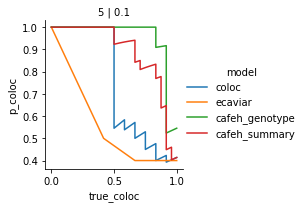

In [12]:
models = query.model.unique()
#models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models)]
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_study')
g.map(_plot_pr, 'true_coloc', 'p_coloc')
g.add_legend()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

### Precision Recall Gain Curves

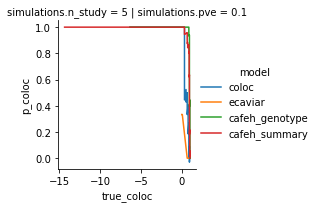

In [13]:
#models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_study')
g.map(_plot_prg, 'true_coloc', 'p_coloc')
g.add_legend();